In [1]:
%reload_ext autoreload

#%reset

import numpy as np
from scipy.stats import poisson
from astropy import units

import matplotlib.pyplot as pl
import matplotlib

import healpy as hp

#For making corner plots
from getdist import plots, MCSamples

import pdb

import EPDFABC as epdfabc
import subhalos as subs

import pickle as pk

import elfi
import graphviz



#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True


matplotlib.use('PS')

%matplotlib inline

#notes:
-assume dark matter signal is isotropic (i.e. compute P(C) at single psi)
-get dark matter spectrum
-implement background drawing
-run ABC


## Example: analyzing the photon count distribution from dark matter annihilation in subhalos

We first compute the PDF of photon counts using the Fourier transform tricks described in e.g. https://arxiv.org/abs/0810.1284v2.

Then, using this PDF, we generate a mock data set assuming some spectrum for the dark matter annihilation.

Finally, we use ABC to analyze this data set to make sure we recover the input parameters.  In this example, we'll consider only one parameter: the normalization of the dark matter signal, which we call PhiPP (PP = short for particle physics).



In [2]:
# Settings for subhalo analysis

physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = 'fast')

N_E_bins = 1
N_pix = int(4.*np.pi/obs_settings['Omega_pixel'])
N_side = int(np.sqrt(N_pix/12.0))
maxc = 10

print(physics_settings)
print(obs_settings)
print("N_side = ", N_side)

{'R_G': 220, 'd_sun': 8.5, 'M_max': 10000000000.0, 'M_min': 500.0, 'PhiPP': 1.0, 'n': 0, 'beta': 1.9}
{'area': 2000.0, 'obs_time': 5.0, 'fov_factor': 0.2, 'Omega_pixel': 0.0010226538585904274, 'psi': 0.6981317007977318}
N_side =  32


In [3]:
# Compute the PDF of photon counts using the Fourier transform trick.  Note that this can be slow.

counts = np.arange(0,maxc)
pc, f_pf_precomputed, pf_pf_precomputed = subs.get_pc(counts, physics_settings, fft_settings, \
                                                      obs_settings, return_fpf = True)

0.926860774343763


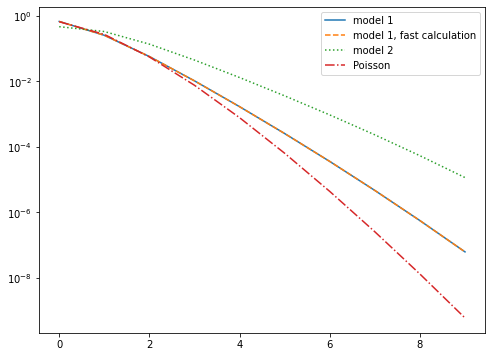

In [4]:
# In order to speed our analysis, we'll using a pre-computed P(F).  Then,changing PhiPP amounts to 
# just rescaling this function, and convolving with a Poisson distribution to get P(C).

#fast P(C) calculation using pre-computed P(F)
default_phipp = 1.0
pc_fast1 = subs.get_pc_fast(counts, f_pf_precomputed, pf_pf_precomputed, physics_settings, obs_settings, default_phipp = default_phipp)
physics_settings2 = physics_settings.copy()
physics_settings2['PhiPP'] = 2.0
pc_fast2 = subs.get_pc_fast(counts, f_pf_precomputed, pf_pf_precomputed, physics_settings2, obs_settings, default_phipp = default_phipp)   
print(np.sum(pc_fast1))

poisson_pc = poisson.pmf(counts, np.sum(pc*counts/np.sum(pc)))

fig, ax = pl.subplots(1,1, figsize = (8,6))
ax.plot(counts, pc/np.sum(pc), label = 'model 1')
ax.plot(counts, pc_fast1/np.sum(pc_fast1), ls = 'dashed', label = 'model 1, fast calculation')
ax.plot(counts, pc_fast2/np.sum(pc_fast2), ls = 'dotted', label = 'model 2')
ax.plot(counts, poisson_pc, ls = 'dashdot', label = 'Poisson')
ax.set_yscale('log')
ax.legend()


si =  0


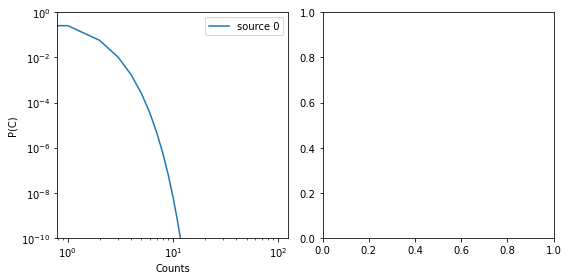

In [5]:
#set up wrappers for pdf functions
def pdf_wrapper(params, counts):
    physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = 'fast')
    physics_settings['PhiPP'] = params[0]
    pc = subs.get_pc_fast(counts, f_pf_precomputed, pf_pf_precomputed, physics_settings, obs_settings, default_phipp = default_phipp)
    #777777 does this make sense?
    pc = pc/np.sum(pc)
    return pc

def spec_wrapper(params, energy):
    param_dict = {'power_law':2.}
    return subs.mock_spectrum(param_dict, energy)

PDF_and_spectra = [[pdf_wrapper, spec_wrapper]]
isotropic = True
energy_range = np.array([1., 50.])
count_range = np.array([0., 100.])
num_energy_bins = 1 #necessary since we want to compute exact likelihood
param_names = ['PhiPP']
param_labels = ['\\Phi_{PP}']
param_min = np.array([.1])
param_max = np.array([1.9])
param_range = [param_min, param_max]
param_true = np.array([1.])

is_isotropic_list = [True]
is_poisson_list = [False]

######elfi######
priors = []
for i in np.arange(len(param_names)):
    priors.append(elfi.Prior('uniform', param_min[i], param_max[i] - param_min[i], name=param_names[i]))
################

counts = np.arange(0,count_range[1])
energies = np.linspace(energy_range[0], energy_range[1], num = 100)

fig, ax = pl.subplots(1,2, figsize = (8,4))
for si in range(0,len(PDF_and_spectra)):
    print("si = ", si)
    ax[0].plot(counts, PDF_and_spectra[si][0](param_true, counts), label = 'source '+str(si))
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel('Counts')
ax[0].set_ylabel('P(C)')
ax[0].legend()
ax[0].set_ylim((1.0e-10, 1.0))
fig.tight_layout()

In [6]:
def lnprior(params):
    return 0.

# initialize the EPDFABC object
my_abc = epdfabc.EPDFABC(param_range)

#Setup for binned analysis
#my_abc.setup_binned(PDF_and_spectra, isotropic, count_range, energy_range, verbose = False)
my_abc.setup_binned(PDF_and_spectra, is_isotropic_list, is_poisson_list, count_range, \
                    energy_range, num_energy_bins, obs_settings['Omega_pixel'], verbose = False)
my_abc.add_lnprior(lnprior)

dict_keys(['physics_settings', 'obs_settings', 'fft_settings', 'obs_data', 'N_E_bins', 'maxc'])


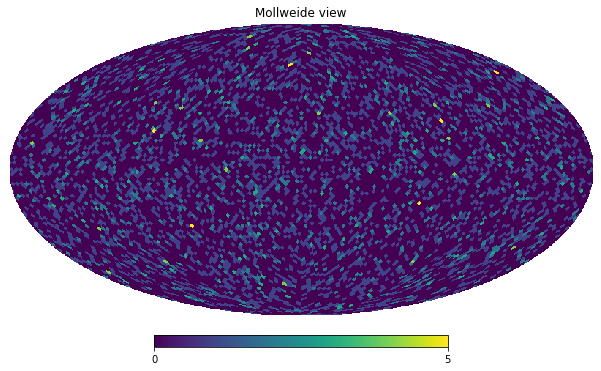

In [7]:
skydict = pk.load(open("./data/skymaps/skymap_for_exactlikelihood_v02.pk", 'rb'))
print(skydict.keys())
obs_data = skydict['obs_data']
hp.mollview(obs_data[:,0])

In [8]:
if False:
    #Create mock data with "true" parameters
    obs_data = my_abc.generate_mock_data_binned(param_true, N_pix = N_pix, N_energy = N_E_bins, verbose = True)[0,:,:]
obs_data.shape



(12288, 1)

In [9]:
#Get posterior using ABC
N_samples = 2665
batch_size = 1
summary_properties = {'type': 'histogram' ,'Nbins':10, 'Cmax_hist': 10, 'Cmin_hist': 0}
######elfi######
from functools import partial
obs_data = np.array([obs_data])
fn_simulator = partial(my_abc.generate_mock_data_binned_ELFI, N_pix = N_pix, epdf_object=my_abc)
sim = elfi.Simulator(fn_simulator, *priors, observed=obs_data)
summ = elfi.Summary(my_abc.get_summary_from_binned, sim, summary_properties)
d = elfi.Distance('euclidean', summ)

#rej = elfi.Rejection(d, batch_size = batch_size)
smc_adap = elfi.AdaptiveThresholdSMC(d, batch_size = batch_size, q_threshold = 0.995)

elfi.draw(d)

#%time result_rej = rej.sample(N_samples, quantile=0.01)
%time result_smc_at = smc_adap.sample(N_samples, max_iter = 10)
result_smc_at.summary(all=True)

keys = list(result_smc_at.samples)
posterior_samples = result_smc_at.samples[keys[0]]
#keys = result_rej.samples.keys()
#posterior_samples = result_rej.samples[keys[0]]

pk.dump(posterior_samples, open("./data/ABC_posteriors/BinnedABCposterior_samples_atsmc.pk", 'wb'))
################
#posterior_samples = my_abc.run_abc_binned(obs_data, N_samples, summary_properties, epsilon = 10000., verbose = True)
#pk.dump(posterior_samples, open("./data/BinnedABCposterior_samples.pk", 'wb'))

#print("posterior samples shape = ", posterior_samples.shape)
#print(posterior_samples)

ABC-SMC Round 1 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 2 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 3 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 4 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 5 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 6 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 7 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 8 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 9 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 10 / 10
Progress [==================================================] 100.0% Complete
CPU times

Removed no burn in


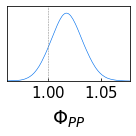

In [10]:
if (1):
    #Getdist requires specification of parameter ranges to get accurate contours
    ranges = {}
    markers={} #true parameter values
    for ii in range(0,len(param_min)):
        ranges[param_names[ii]] = [param_min[ii], param_max[ii]]
        markers[param_names[ii]] = param_true[ii]
        
    psamps = MCSamples(samples = posterior_samples, ranges = ranges, names = param_names, labels = param_labels)    


    g = plots.get_subplot_plotter()
    g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
    g.settings.axes_fontsize=18
    g.settings.legend_fontsize = 26
    g.settings.axes_labelsize = 22
    g.triangle_plot(psamps, filled=True, markers=markers)